In [1]:
%load_ext autoreload
%autoreload 

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from multiprocess import Pool, cpu_count

from fem2D import *
from simpleMeshes import *

nprocesses = cpu_count()
print(f"Code parallelized with {nprocesses} processes.")

Code parallelized with 12 processes.


In [3]:
# chargement du maillage

eraseCurrentMesh()

N = 2       # elements order

# # BAR
# Lx = 1000.0   
# Ly = 100.0
# dx = 50.0    # elements size
# elements, nodes = rectangleMesh(Lx, Ly, dx, N, botTop=True)
# Δx = dx/(N+1)

# BUILDING
file = "../meshes/building2.msh"
regions = [
    (1, 3),
    (1, 5),
    (1, 2),
    (1, 4),
    ]
Δx = 0.25/(N+1)
elements, nodes = readGmsh4(file, regions) 

dof = len(nodes)
print(f"Nombre de noeuds : {dof}")
print(f"Soit {2*dof} degré de liberté pour un champ 2D")

Nombre de noeuds : 3133
Soit 6266 degré de liberté pour un champ 2D


<AxesSubplot:>

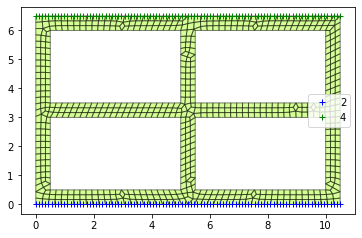

In [4]:
plotMesh(elements, nodes, [2,4]) 

In [5]:
# Chargement des points/poids d'intégration de GLL + dérivée des interpolateurs lagrangiens sur ces points

N = int(np.sqrt(len(elements[0].nodes))) - 1

if N == 1:
    raise(Exception("Please use classical FEM (linear) for order 1 mesh"))

xi,w,dh = readGLL(N)

print(f"{N=}")
print(f"{xi=}")

N=2
xi=array([-1.,  0.,  1.])


In [6]:
# Pour chaque élément calcul:
# - du jacobien
# - de l'inverse de la matrice jacobienne
# La transformation depuis un élément quelconque vers l'élément de référence est l'interpolation bilinéaire

duphi = shapeFunctions["P1"]["duphi"]
dvphi = shapeFunctions["P1"]["dvphi"]

def computeJacobian(e):
        
    coords = e.getCoords()
    X, Y = coords[:,0], coords[:,1]
    
    Je11 = np.zeros((N+1,N+1))
    Je21 = np.zeros((N+1,N+1))
    Je12 = np.zeros((N+1,N+1))
    Je22 = np.zeros((N+1,N+1))
    
    e.detJ = np.zeros((N+1,N+1))
    
    e.iJe11 = np.zeros((N+1,N+1))
    e.iJe21 = np.zeros((N+1,N+1))
    e.iJe12 = np.zeros((N+1,N+1))
    e.iJe22 = np.zeros((N+1,N+1))

    dxdu = interp(duphi, X)
    dxdv = interp(dvphi, X)        
    dydu = interp(duphi, Y)
    dydv = interp(dvphi, Y)
    
    
    for i in range(N+1):
        for j in range(N+1):
            
            Je11[i,j] = dxdu(xi[i], xi[j])
            Je21[i,j] = dxdv(xi[i], xi[j])
            Je12[i,j] = dydu(xi[i], xi[j])
            Je22[i,j] = dydv(xi[i], xi[j])
            
            e.detJ[i,j] = Je11[i,j]*Je22[i,j] - Je21[i,j]*Je12[i,j]
            
            e.iJe11[i,j] =  Je22[i,j]/e.detJ[i,j]
            e.iJe22[i,j] =  Je11[i,j]/e.detJ[i,j]
            e.iJe21[i,j] = -Je21[i,j]/e.detJ[i,j]
            e.iJe12[i,j] = -Je12[i,j]/e.detJ[i,j]
            
    return e
    
with Pool(nprocesses) as p:
    Element.id = 0
    elements = list(tqdm(p.imap(computeJacobian, elements), total=len(elements)))

100%|██████████| 677/677 [00:00<00:00, 764.87it/s] 


In [7]:
E = 11       # module d'Young
ν = 0.15     # coefficient de Poisson

# paramètres de Lamé
λ = (E*ν) / ((1+ν)*(1-2*ν))
μ = E / (2*(1+ν))

In [8]:
# calcul des matrices élémentaires

δ = np.eye(N+1)

def computeStiffnes(e):
    
    # KeTemp = np.zeros((N+1,N+1,N+1,N+1))
    e.Ke = np.zeros((2*(N+1)**2,2*(N+1)**2))
    
    Kdxdx = np.zeros((N+1,N+1,N+1,N+1))
    Kdydy = np.zeros((N+1,N+1,N+1,N+1))
    Kdxdy = np.zeros((N+1,N+1,N+1,N+1))
    Kdydx = np.zeros((N+1,N+1,N+1,N+1))
    
    for a in range(N+1):
        for b in range(N+1):
            for c in range(N+1):
                for d in range(N+1):
                       
                        for p in range(N+1):
                            for q in range(N+1):
                                
                                Kdxdx[a,b,c,d] += w[p]*w[q] * (e.iJe11[p,q]*dh[a,p]*δ[b,q] + e.iJe12[p,q]*dh[b,q]*δ[a,p])*(e.iJe11[p,q]*dh[c,p]*δ[d,q] + e.iJe12[p,q]*dh[d,q]*δ[c,p]) * e.detJ[p,q]
                                Kdydy[a,b,c,d] += w[p]*w[q] * (e.iJe21[p,q]*dh[a,p]*δ[b,q] + e.iJe22[p,q]*dh[b,q]*δ[a,p])*(e.iJe21[p,q]*dh[c,p]*δ[d,q] + e.iJe22[p,q]*dh[d,q]*δ[c,p]) * e.detJ[p,q]
                                Kdxdy[a,b,c,d] += w[p]*w[q] * (e.iJe11[p,q]*dh[a,p]*δ[b,q] + e.iJe12[p,q]*dh[b,q]*δ[a,p])*(e.iJe21[p,q]*dh[c,p]*δ[d,q] + e.iJe22[p,q]*dh[d,q]*δ[c,p]) * e.detJ[p,q]
                                Kdydx[a,b,c,d] += w[p]*w[q] * (e.iJe21[p,q]*dh[a,p]*δ[b,q] + e.iJe22[p,q]*dh[b,q]*δ[a,p])*(e.iJe21[p,q]*dh[c,p]*δ[d,q] + e.iJe22[p,q]*dh[d,q]*δ[c,p]) * e.detJ[p,q]
                                
    for i in range(2*(N+1)**2):
        for j in range(2*(N+1)**2):
            
            a,b = i//2//(N+1), i//2%(N+1)
            c,d = j//2//(N+1), j//2%(N+1)
            
            if i%2 == 0 and j%2 == 0:
                
                e.Ke[i,j] = (2*λ+μ)*Kdxdx[a,b,c,d] + μ*Kdydy[a,b,c,d]             
                
            if i%2 == 0 and j%2 != 0:
                
                e.Ke[i,j] = λ*Kdxdy[a,b,c,d] + μ*Kdydx[a,b,c,d]      
            
            if i%2 != 0 and j%2 == 0:
                
                e.Ke[i,j] = λ*Kdydx[a,b,c,d] + μ*Kdxdy[a,b,c,d]             
                
            if i%2 != 0 and j%2 != 0:
                
                e.Ke[i,j] = (2*λ+μ)*Kdydy[a,b,c,d] + μ*Kdxdx[a,b,c,d] 
                                
    return e

# elements = list(tqdm(map(computeStiffnes, elements), total=len(elements)))

with Pool(nprocesses) as p:
    Element.id = 0
    elements = list(tqdm(p.imap(computeStiffnes, elements), total=len(elements)))

100%|██████████| 677/677 [00:01<00:00, 509.21it/s]


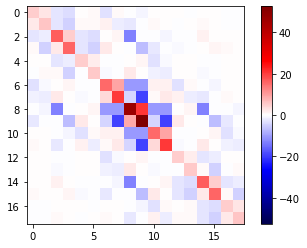

In [9]:
Ke = elements[3].Ke
minKe = min(Ke.min(), -Ke.max())
plt.imshow(Ke, cmap="seismic", vmin=minKe, vmax=-minKe)
plt.colorbar()

In [10]:
# assemblage

K = np.zeros((2*dof,2*dof))
F = np.zeros(2*dof)

for e in tqdm(elements):
    for (i,n1) in enumerate(e.nodes):
        for (j,n2) in enumerate(e.nodes):
            K[2*n1.id,2*n2.id] += e.Ke[2*i,2*j]
            K[2*n1.id+1,2*n2.id] += e.Ke[2*i+1,2*j]
            K[2*n1.id,2*n2.id+1] += e.Ke[2*i,2*j+1]
            K[2*n1.id+1,2*n2.id+1] += e.Ke[2*i+1,2*j+1]
            

100%|██████████| 677/677 [00:00<00:00, 3068.40it/s]


In [11]:
# Bar
# sideA, sideB = 5, 3

# Building
sideA, sideB = 2, 4

ua1, ua2 = Δx/10, Δx/10
ub1, ub2 = -Δx/10, -Δx/10

for n in nodes:
    
    if n.region == sideA:
        K[2*n.id,:] = 0
        K[2*n.id, 2*n.id] = 1
        K[2*n.id+1,:] = 0
        K[2*n.id+1, 2*n.id+1] = 1
        
        F[2*n.id] = ua1
        F[2*n.id+1] = ua2
        
    if n.region == sideB:
        K[2*n.id,:] = 0
        K[2*n.id, 2*n.id] = 1
        K[2*n.id+1,:] = 0
        K[2*n.id+1, 2*n.id+1] = 1
        
        F[2*n.id] = ub1
        F[2*n.id+1] = ub2


In [12]:
%matplotlib tk
iSubset = 100
minK = min(K[:iSubset, :iSubset].min(), -K[:iSubset, :iSubset].max())
plt.imshow(K[:iSubset, :iSubset], cmap="seismic", vmin=minK, vmax=-minK)
plt.colorbar()

In [13]:
# Résolution du système

U = np.linalg.solve(K, F)

In [14]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_aspect("equal", "box")

plotDeformedMesh(elements, U, ax, s=20)

In [15]:
import warnings
warnings.filterwarnings("error")

In [145]:
# compute strain-stress

for e in elements:
    
    e.εxxNodes, e.εxx = [], []
    e.εyyNodes, e.εyy = [], []
    e.εxyNodes, e.εxy = [], []

    for i in range(len(e.nodes)):
        if i > 0 and (i+1) % (N+1) == 0:
            continue
        n1,n2 = e.nodes[i], e.nodes[i+1]
        e.εxxNodes.append(((n1.x+n2.x)/2, (n1.y+n2.y)/2))
        try:
            e.εxx.append((U[2*n2.id] - U[2*n1.id])/(n2.x-n1.x))
        except:
            continue
        
    for i in range(len(e.nodes)-(N+1)):
        n1,n2 = e.nodes[i], e.nodes[i+N+1]
        e.εyyNodes.append(((n1.x+n2.x)/2, (n1.y+n2.y)/2))
        try:
            e.εyy.append((U[2*n2.id+1] - U[2*n1.id+1])/(n2.y-n1.y))
        except:
            continue
        
    for i in range(len(e.nodes)-3):
        if i > 0 and (i+1) % (N+1) == 0:
            continue
        n1,n2,n3,n4 = e.nodes[i], e.nodes[i+1], e.nodes[i+N+1], e.nodes[i+N+2]
                
        e.εxyNodes.append(((n1.x+n2.x+n3.x+n4.x)/4, (n1.y+n2.y+n3.y+n4.y)/4))
        try:
            e.εxy.append(
                ((U[2*n2.id+1] - U[2*n1.id+1])/(n2.x-n1.x) +
                (U[2*n4.id+1] - U[2*n3.id+1])/(n4.x-n3.x) +
                (U[2*n3.id] - U[2*n1.id])/(n3.y-n1.y) +
                (U[2*n4.id] - U[2*n2.id])/(n4.y-n2.y)) * 0.5
                )
        except:
            continue
        
    e.εxx_mean = sum(e.εxx)/len(e.εxx)    
    e.εyy_mean = sum(e.εyy)/len(e.εyy)    
    e.εxy_mean = sum(e.εxy)/len(e.εxy)
    

In [133]:
import matplotlib as mpl

In [150]:
fig, ax = plt.subplots(figsize = (6,6))

εxx = [e.εxx_mean for e in elements]
εyy = [e.εyy_mean for e in elements]
εxy = [e.εxy_mean for e in elements]

toPlot = [abs(ε) for ε in εxx]

print(min(toPlot))
print(max(toPlot))

cNorm  = mpl.colors.LogNorm(vmin=min(toPlot), vmax=max(toPlot))
scalarMap = plt.cm.ScalarMappable(norm=cNorm, cmap="viridis")


for e in elements:
    coords = e.getCoords()
    ax.fill(coords[:,0], coords[:,1], color=scalarMap.to_rgba(e.εxx_mean), alpha=0.5, ec="k")


ax.set_aspect("equal", "box")

4.0632267006384854e-08
19.46997130281
